In [119]:
pip install keras

In [120]:
pip install tensorflow

In [121]:
from matplotlib import pyplot as plt
# %matplotlib inline
import numpy as np
import pandas as pd
import h5py
import os.path
import seaborn as sns
from scipy import stats

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GRU
from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, GlobalAveragePooling1D
from keras.utils import np_utils
from keras import optimizers


!curl https://raw.githubusercontent.com/kyungmanyu/deeplearing/master/data1.zip\
    -o data1.zip

!unzip -oq data1.zip

!curl https://raw.githubusercontent.com/kyungmanyu/deeplearing/master/data2.zip\
    -o data2.zip

!unzip -oq data2.zip


In [122]:
# 센서 1만 데이터 불러오기
# h5 데이터는 이 파일과 같은 폴더에 있어야 함... 죄송함댜ㅎㅎ
Label_size = 32
sensor1_data = np.empty((0,765+Label_size),int)
position_label = np.empty((0,Label_size),int)
label_cnt = 0
sensor1_data_training = np.empty((0,765+Label_size),int)
sensor1_data_test = np.empty((0,765+Label_size),int)
print(position_label)
for ii in range(12346):
#for ii in range(2):
    filename ='20201022_Depth_{}.h5'.format(ii)
    
    if os.path.isfile(filename):
        h5f = h5py.File(filename,'r')
        a_dset_keys = list(h5f.keys())
        ds_data = h5f[a_dset_keys[0]]
        sensor1 = ds_data[:,0,:]    
        
        sensor1 = np.array(sensor1)
        
        #Scale down_ 10분의 1
        sensor1 = sensor1[0::10]
        
        #print("Sensor1_data:", sensor1.shape)
        #print("Scale_down_data:", scale_down_sensor1.shape)
        
        #전체 데이터 예시
        #########################################################################################################
        position_label = np.zeros((sensor1.shape[0],Label_size))

        #32bit coding
        if(ii == 0):
            aa = 1
        else:
            position_label[:,label_cnt] = 1
        label_cnt += 1
        
        sensor1 = np.append(sensor1, position_label, axis=1)
        
        sensor_len = len(sensor1)
        columns = range(0,sensor_len)
        training_per = round(sensor_len*0.8)
        test_per = sensor_len-training_per
        training_data = sensor1[:training_per]
        test_data = sensor1[training_per+1:]
        
        sensor1_data_training = np.append(sensor1_data_training, training_data, axis = 0)
        sensor1_data_test = np.append(sensor1_data_test,test_data,axis = 0)
        print("training_data:", sensor1_data_training.shape)
        print("test_data",sensor1_data_test.shape)
        
        sensor1_data= np.append(sensor1_data,sensor1,axis = 0)
        
        #print(sensor1_data.shape)
        #print(sensor1_data)
        
        
        #sensor1_data_training = np.append(sensor1_data_training, sensor1[:training_per], axis = 0)
        #sensor1_data_test= np.append(sensor1_data_test, sensor1[training_per+1:], axis = 0)
        #sensor1_data_training = np.append(sensor1_data_training, sensor1_data_training_current,axis = 0)
        #sensor1_data_test = np.append(sensor1_data_test,sensor1_data_test_current,axis = 0)
        #print("Total data length:",sensor1_data.shape)
        #print("training data length:",sensor1_data_training.shape)
        #print("test data length:",sensor1_data_test.shape)
        
        print("{} done".format(ii))
    else:
        a = 1
        

position_label.shape

[]
training_data: (56, 797)
test_data (13, 797)
0 done
training_data: (587, 797)
test_data (145, 797)
1 done
training_data: (1078, 797)
test_data (267, 797)
2 done
training_data: (1542, 797)
test_data (382, 797)
3 done
training_data: (1998, 797)
test_data (495, 797)
4 done
training_data: (2659, 797)
test_data (659, 797)
5 done
training_data: (2917, 797)
test_data (723, 797)
12 done
training_data: (3407, 797)
test_data (844, 797)
13 done
training_data: (3876, 797)
test_data (960, 797)
14 done
training_data: (4014, 797)
test_data (993, 797)
15 done
training_data: (4414, 797)
test_data (1092, 797)
23 done
training_data: (4820, 797)
test_data (1192, 797)
24 done
training_data: (5158, 797)
test_data (1275, 797)
25 done
training_data: (5422, 797)
test_data (1340, 797)
34 done
training_data: (5622, 797)
test_data (1389, 797)
35 done
training_data: (5808, 797)
test_data (1434, 797)
45 done
training_data: (6258, 797)
test_data (1546, 797)
123 done
training_data: (6672, 797)
test_data (1648, 797

(436, 32)

In [123]:
sc = preprocessing.StandardScaler()
#Training Data, test Data => DataFrame화
sensor_len_train = len(sensor1_data_training)
columns_train = range(0,sensor_len_train)
sensor_len_test = len(sensor1_data_test)
columns_test = range(0,sensor_len_test)

df_train = pd.DataFrame(data = sensor1_data_training, index = columns_train)
df_test = pd.DataFrame(data = sensor1_data_test, index = columns_test)

#Scaling
#df_train[:,:764] = sc.fit_transform(df_train[:764])
#df_test[:,:764] = sc.transform(df_test[:,:764])

# train 데이터,Test 데이터 준비
X_train = df_train.loc[:,:764]
X_test = df_test.loc[:,:764]
#y_train = df_train.loc[:,765:]
#y_test = df_test.loc[:,765:]
y_train = sensor1_data_training[:,765:]
y_test = sensor1_data_test[:,765:]

#Scaling
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#CNN 모델 적용을 위한 reshape
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
#X_train = X_train.values.reshape((X_train.shape[0],X_train.shape[1],1))
#X_test = X_test.values.reshape((X_test.shape[0],X_test.shape[1],1))
#y_train.shape
#y_train
y_test
X_test

array([[[-1.19160116],
        [-1.19170373],
        [-1.19174387],
        ...,
        [ 0.64847798],
        [ 0.64849115],
        [ 0.6502984 ]],

       [[-1.1701143 ],
        [-1.17065934],
        [-1.1711225 ],
        ...,
        [ 0.71410754],
        [ 0.71412114],
        [ 0.7077397 ]],

       [[-1.19374984],
        [-1.1959126 ],
        [-1.19586814],
        ...,
        [ 0.82075559],
        [ 0.82076986],
        [ 0.8226223 ]],

       ...,

       [[ 0.61329483],
        [ 0.61390438],
        [ 0.61262597],
        ...,
        [-0.36057661],
        [-0.36056984],
        [-0.36723319]],

       [[ 0.56817243],
        [ 0.56971118],
        [ 0.56932109],
        ...,
        [-0.3687803 ],
        [-0.36877359],
        [-0.37543909]],

       [[ 0.7529594 ],
        [ 0.75279732],
        [ 0.75491342],
        ...,
        [-0.1800953 ],
        [-0.18008739],
        [-0.18670339]]])

In [124]:
#add_feature를 위한 함수 정의
# 우리 데이터 형태에 맞게 수정-> 현재 Column 인덱스를 숫자 0~764로 정의
def find_peak_global_rolling(df, thres, window):
    df_peak = df[np.abs(df) > thres]
    df_peak.columns = df.columns + '_peak'

    df_count = df_peak.rolling(window, min_periods=1).count()
    df_count.columns = df.columns + '_count'+ str(window)
    return df_peak, df_count
def find_peak_global(df, thres):
    df_peak = df[np.abs(df) > thres]
    df_peak.columns = df.columns + '_peak'
    return df_peak
def rolling_max(df, window):
    df_max = df.rolling(window, min_periods=1).max()
    #df_max.columns = [col + "_max" + str(window) for col in df.columns]
    df_max.columns = [col for col in df.columns]
    return df_max
def rolling_std(df, window):
    df_std = df.rolling(window, min_periods=1).std().fillna(0)
    #df_std.columns = [col + "_std" + str(window) for col in df.columns]
    df_std.columns = [col for col in df.columns]
    return df_std
def rolling_average(df, window):
    df_av = df.rolling(window, min_periods=1).mean()
    #df_av.columns = [col + "_av" + str(window) for col in df.columns]
    df_av.columns = [col for col in df.columns]
    return df_av

In [137]:
# #CNN모델
# model_m = Sequential()
# model_m.add(Conv1D(128, 10, activation='relu',input_shape=(765,1)))
# model_m.add(MaxPooling1D(3))
# #model_m.add(Conv1D(64, 10, activation='relu'))
# #model_m.add(MaxPooling1D(3))
# model_m.add(Conv1D(128, 10, activation='relu'))
# model_m.add(MaxPooling1D(3))
# model_m.add(Flatten())
# model_m.add(Dense(128, activation = 'relu'))
# #과대적합 발생 시, Dropout 추가
# model_m.add(Dropout(0.7))
# model_m.add(Dense(32, activation='softmax'))
# print(model_m.summary())


#CNN모델
model_m = Sequential()
model_m.add(Conv1D(64, 5, activation='relu',input_shape=(765,1)))
model_m.add(MaxPooling1D(2))
model_m.add(Conv1D(64, 5, activation='relu'))
model_m.add(MaxPooling1D(2))
model_m.add(Conv1D(64, 5, activation='relu'))
model_m.add(MaxPooling1D(2))
model_m.add(Dropout(0.3))
model_m.add(Conv1D(64, 5, activation='relu'))
model_m.add(MaxPooling1D(2))
model_m.add(Conv1D(128, 5, activation='relu'))
model_m.add(MaxPooling1D(2))
model_m.add(Flatten())
model_m.add(Dense(128, activation = 'relu'))
#과대적합 발생 시, Dropout 추가
model_m.add(Dropout(0.3))
model_m.add(Dense(32, activation='softmax'))
print(model_m.summary())

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_61 (Conv1D)           (None, 756, 128)          1408      
_________________________________________________________________
max_pooling1d_57 (MaxPooling (None, 252, 128)          0         
_________________________________________________________________
conv1d_62 (Conv1D)           (None, 243, 128)          163968    
_________________________________________________________________
max_pooling1d_58 (MaxPooling (None, 81, 128)           0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 10368)             0         
_________________________________________________________________
dense_38 (Dense)             (None, 128)               1327232   
_________________________________________________________________
dropout_20 (Dropout)         (None, 128)             

In [ ]:
callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
]
###sgd
#sgd = optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
#model_m.compile(loss='categorical_crossentropy',
#                optimizer=sgd, metrics=['accuracy'])

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

    
history = model_m.fit(X_train,
                      y_train,
                      batch_size=30,
                      epochs=5,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Epoch 1/5
314/314 [==============================] - 95s 302ms/step - loss: 0.6549 - accuracy: 0.7827 - val_loss: 15.5194 - val_accuracy: 0.0000e+00
Epoch 2/5
314/314 [==============================] - 109s 347ms/step - loss: 0.2288 - accuracy: 0.9116 - val_loss: 24.8213 - val_accuracy: 0.0187
Epoch 3/5
314/314 [==============================] - 106s 337ms/step - loss: 0.1732 - accuracy: 0.9281 - val_loss: 29.1755 - val_accuracy: 0.0934
Epoch 4/5
314/314 [==============================] - 103s 328ms/step - loss: 0.1510 - accuracy: 0.9346 - val_loss: 24.8192 - val_accuracy: 0.1639
Epoch 5/5
204/314 [==================>...........] - ETA: 36s - loss: 0.1383 - accuracy: 0.9368

In [127]:
def show_results(y_test, y_pred):
    max_y_pred_test = np.argmax(y_pred, axis=1)
    max_y_test = np.argmax(y_test, axis=1)
    #show_confusion_matrix(max_y_test, max_y_pred_test)
    print(classification_report(max_y_test, max_y_pred_test))
    

In [128]:
y_test.shape

(2910, 32)

In [129]:
np.argmax(y_test, axis =1)

array([ 0,  0,  0, ..., 31, 31, 31], dtype=int64)

In [130]:
y_pred.shape

(1441, 32)

In [134]:
y_pred = model_m.predict(X_test)
show_results(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.91      1.00      0.95       132
           2       1.00      1.00      1.00       122
           3       1.00      1.00      1.00       115
           4       1.00      1.00      1.00       113
           5       1.00      1.00      1.00       164
           6       0.39      1.00      0.56        64
           7       1.00      1.00      1.00       121
           8       1.00      1.00      1.00       116
           9       1.00      1.00      1.00        33
          10       1.00      1.00      1.00        99
          11       1.00      1.00      1.00       100
          12       1.00      1.00      1.00        83
          13       1.00      1.00      1.00        65
          14       1.00      1.00      1.00        49
          15       1.00      1.00      1.00        45
          16       0.41      1.00      0.58       112
          17       1.00    

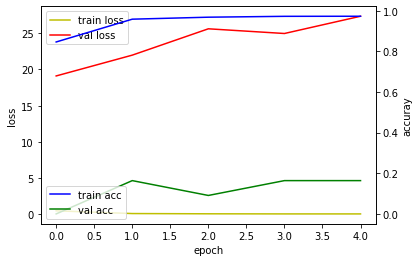

In [135]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

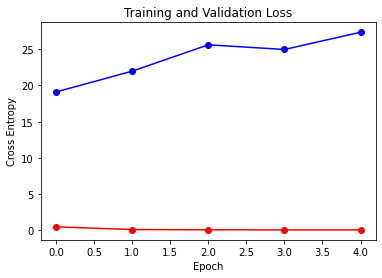

In [136]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(loss, 'ro-')
plt.plot(val_loss, 'bo-')
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')
plt.show()